### Importing Libraries 

In [ ]:
import numpy as np
import os
import json 
from tqdm import tqdm 

from skimage.transform import resize
from skimage.feature import hog
from skimage.io import imread
from skimage.filters import gabor

from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Extracing both features sequentially in a single function 

In [1]:
def extract_combined_features(image_path, target_size=(128, 64)):
    # Read and preprocess the image
    image = imread(image_path, as_gray=True)
    image_resized = resize(image, target_size, anti_aliasing=True)

    # Extract HOG features
    hog_features = hog(image_resized, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False, feature_vector=True)

    # Extract Gabor features
    gabor_responses = []
    orientations = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]
    frequencies = [0.2, 0.4, 0.6, 0.8]
    for theta in orientations:
        for frequency in frequencies:
            filtered, _ = gabor(image_resized, frequency=frequency, theta=theta)
            gabor_responses.extend(np.abs(filtered).flatten())
    
    hist, _ = np.histogram(gabor_responses, bins=20, range=(0, np.max(gabor_responses)))
    hist = hist.astype(float) / hist.sum()  # Normalize histogram

    # Combine HOG and Gabor features
    combined_features = np.hstack([hog_features, hist])
    return combined_features


In [2]:
combined_features = []
labels = []

subject_ids = ['SN001', 'SN002', 'SN003', 'SN004', 'SN021', 'SN023', 'SN024', 'SN025', 'SN026', 'SN027', 'SN028', 'SN029', 'SN030', 'SN031', 'SN032']
subject_ids = ['SN001', 'SN002', 'SN003', 'SN026', 'SN027', 'SN028', 'SN029', 'SN030', 'SN031', 'SN032']
cropped_dir = "croppedImg" 

for subject_id in tqdm(subject_ids, desc="Processing subjects"):
    json_file = os.path.join('json', f'{subject_id}.json')
    subject_dir = os.path.join(cropped_dir, subject_id)
    with open(json_file, 'r') as file:
        data = json.load(file)
        for frame_data in data:
            img_path = os.path.join(subject_dir, f"{frame_data['id']}.jpg")
            if os.path.exists(img_path):
                try:
                    # Extract combined features
                    features = extract_combined_features(img_path)
                    combined_features.append(features)
                    # Extract labels (AU intensities) with default value of 0 if the key is not present
                    au_intensities = [frame_data.get(f'au{j}', 0) for j in range(1, 27)]
                    labels.append(au_intensities)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")
            else:
                print(f"Warning: The file {img_path} does not exist.")


Processing subjects: 100%|██████████| 10/10 [1:00:58<00:00, 365.89s/it]


### Visualizing Dataset using t-SNE 

/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 48450 samples in 0.074s...
[t-SNE] Computed neighbors for 48450 samples in 401.643s...
[t-SNE] Computed conditional probabilities for sample 1000 / 48450
[t-SNE] Computed conditional probabilities for sample 2000 / 48450
[t-SNE] Computed conditional probabilities for sample 3000 / 48450
[t-SNE] Computed conditional probabilities for sample 4000 / 48450
[t-SNE] Computed conditional probabilities for sample 5000 / 48450
[t-SNE] Computed conditional probabilities for sample 6000 / 48450
[t-SNE] Computed conditional probabilities for sample 7000 / 48450
[t-SNE] Computed conditional probabilities for sample 8000 / 48450
[t-SNE] Computed conditional probabilities for sample 9000 / 48450
[t-SNE] Computed conditional probabilities for sample 10000 / 48450
[t-SNE] Computed conditional probabilities for sample 11000 / 48450
[t-SNE] Computed conditional probabilities for sample 12000 / 48450
[t-SNE] Computed conditional probabilities for 

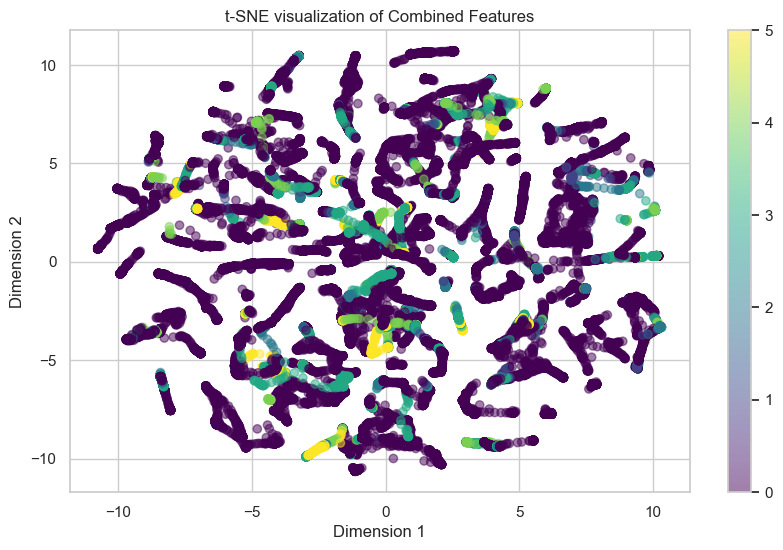

In [3]:

X = np.array(combined_features)
y = np.array(labels)
# Simplify or correct y if necessary, here's a hypothetical correction
y_simplified = np.array([labels[0] for labels in y])  # Replace with your label extraction logic

# Initialize t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
X_tsne = tsne.fit_transform(X)


sns.set(style="whitegrid")
# Plot the result of t-SNE
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_simplified, cmap='viridis', alpha=0.5)
plt.colorbar(scatter)
plt.title('t-SNE visualization of Combined Features')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


### Transforming the data using MultiLabelBinarizer

In [5]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42, stratify=y)

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train) 
y_test = mlb.transform(y_test)

### Comparing RF and KNN

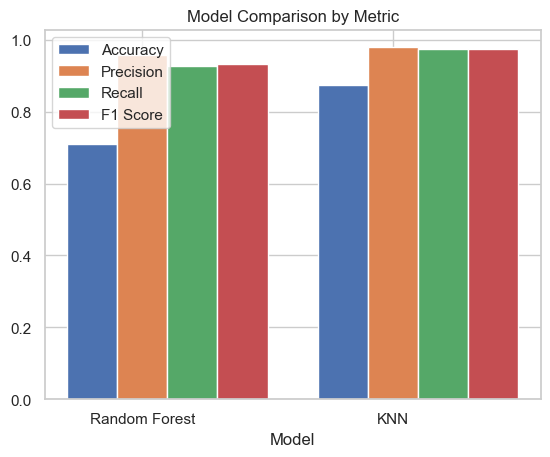

In [6]:

# Wrap classifiers to handle multi-label data
multi_target_rf = RandomForestClassifier()
multi_target_knn = MultiOutputClassifier(KNeighborsClassifier())

models = {
    'Random Forest': multi_target_rf,
    'KNN': multi_target_knn
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),  # Correctly computes subset accuracy
        'Precision': precision_score(y_test, y_pred, average='samples'),
        'Recall': recall_score(y_test, y_pred, average='samples'),
        'F1 Score': f1_score(y_test, y_pred, average='samples')
    }

# Visualization remains the same
n_groups = len(results)
index = np.arange(n_groups)
bar_width = 0.2

# Create the plot
fig, ax = plt.subplots()
for i, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1 Score']):
    scores = [results[model][metric] for model in models]
    ax.bar(index + i * bar_width, scores, bar_width, label=metric)

ax.set_xlabel('Model')
ax.set_title('Model Comparison by Metric')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(models.keys())
ax.legend()

plt.show()

## Running Random Forest Classifier 

In [7]:
# Initialize and train the Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Initialize dictionaries to store the metrics
accuracy_scores = {}
precision_scores = {}
recall_scores = {}
f1_scores = {}

# Calculate metrics for each AU
for i, class_label in enumerate(mlb.classes_):
    accuracy_scores[class_label] = accuracy_score(y_test[:, i], y_pred[:, i])
    precision_scores[class_label] = precision_score(y_test[:, i], y_pred[:, i])
    recall_scores[class_label] = recall_score(y_test[:, i], y_pred[:, i])
    f1_scores[class_label] = f1_score(y_test[:, i], y_pred[:, i])

# Calculate average metrics across all AUs
average_accuracy = np.mean(list(accuracy_scores.values()))
average_precision = np.mean([score for score in precision_scores.values() if not np.isnan(score)])
average_recall = np.mean([score for score in recall_scores.values() if not np.isnan(score)])
average_f1 = np.mean([score for score in f1_scores.values() if not np.isnan(score)])

# Print or return the results
print("Accuracy per AU:", accuracy_scores)
print("Precision per AU:", precision_scores)
print("Recall per AU:", recall_scores)
print("F1 Score per AU:", f1_scores)
print("Average Accuracy:", average_accuracy)
print("Average Precision:", average_precision)
print("Average Recall:", average_recall)
print("Average F1 Score:", average_f1)


Accuracy per AU: {0: 1.0, 1: 0.8958376332989336, 2: 0.8972824217406261, 3: 0.9338837289301686, 4: 0.9173718610251118, 5: 0.9679394564843481}
Precision per AU: {0: 1.0, 1: 0.9284827414949094, 2: 0.88, 3: 0.9112132124674035, 4: 0.9721407624633431, 5: 0.9743589743589743}
Recall per AU: {0: 1.0, 1: 0.7530715005035247, 2: 0.9420724094881399, 3: 0.9675632911392406, 4: 0.359349593495935, 5: 0.29185867895545314}
F1 Score per AU: {0: 1.0, 1: 0.8316281138790036, 2: 0.9099788965933072, 3: 0.9385431988233037, 4: 0.5247328848436882, 5: 0.4491725768321513}
Average Accuracy: 0.9353858502465314
Average Precision: 0.9443659484641049
Average Recall: 0.7189859122637156
Average F1 Score: 0.775675945161909


## Running K-NN Classifier

In [8]:
# Initialize and train the K-Nearest Neighbors model
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

# Predict on the test set
y_pred = knn_model.predict(X_test)

# Initialize dictionaries to store the metrics
accuracy_scores = {}
precision_scores = {}
recall_scores = {}
f1_scores = {}

# Calculate metrics for each AU
for i, class_label in enumerate(mlb.classes_):
    accuracy_scores[class_label] = accuracy_score(y_test[:, i], y_pred[:, i])
    precision_scores[class_label] = precision_score(y_test[:, i], y_pred[:, i])
    recall_scores[class_label] = recall_score(y_test[:, i], y_pred[:, i])
    f1_scores[class_label] = f1_score(y_test[:, i], y_pred[:, i])

# Calculate average metrics across all AUs
average_accuracy = np.mean(list(accuracy_scores.values()))
average_precision = np.mean([score for score in precision_scores.values() if not np.isnan(score)])
average_recall = np.mean([score for score in recall_scores.values() if not np.isnan(score)])
average_f1 = np.mean([score for score in f1_scores.values() if not np.isnan(score)])

# Print or return the results
print("Accuracy per AU:", accuracy_scores)
print("Precision per AU:", precision_scores)
print("Recall per AU:", recall_scores)
print("F1 Score per AU:", f1_scores)
print("Average Accuracy:", average_accuracy)
print("Average Precision:", average_precision)
print("Average Recall:", average_recall)
print("Average F1 Score:", average_f1)


Accuracy per AU: {0: 1.0, 1: 0.9477124183006536, 2: 0.9486068111455108, 3: 0.9785345717234262, 4: 0.9751633986928104, 5: 0.9901616787065703}
Precision per AU: {0: 1.0, 1: 0.9350300020691082, 2: 0.9546763490672343, 3: 0.9787990518830656, 4: 0.9211123723041997, 5: 0.9110032362459547}
Recall per AU: {0: 1.0, 1: 0.9101711983887211, 2: 0.9519350811485643, 3: 0.9800896624472574, 4: 0.8796747967479674, 5: 0.8648233486943164}
F1 Score per AU: {0: 1.0, 1: 0.922433149622372, 2: 0.9533037444520848, 3: 0.9794439320068521, 4: 0.8999168283892431, 5: 0.8873128447596531}
Average Accuracy: 0.9733631464281619
Average Precision: 0.9501035019282603
Average Recall: 0.9311156812378045
Average F1 Score: 0.9404017498717008
